# Problem

Users were presented a new price (test users) and conversiosns were tracked for both test and non-test users. We are tasked to answer the following.

**Questions:**

1. Should the company sell its software for \\$39 or $59? 



2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?



3. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Importing data
First I'll import the two data tables and do some initial cleaning and EDA.
## Results table

In [4]:
results_df = pd.read_csv('test_results.csv')

In [5]:
results_df.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


Looks like a dummy index column we can immeditely drop

In [6]:
results_df = results_df.iloc[:,1:]

In [7]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 19.3+ MB


looks like expected numerical columns are all numerical (no bad characters). Let's check for nans.

In [8]:
len(results_df)-len(results_df.dropna(how='any'))
results_df.groupby('test')['operative_system'].value_counts()

test  operative_system
0     windows             63532
      iOS                 61789
      android             48157
      mac                 16348
      i0S                    66
      wnddows                59
      anroid                 53
      apple                  18
1     windows             37346
      iOS                 33563
      android             26699
      mac                  8708
      i0S                    47
      wnddows                39
      anroid                 26
      apple                  11
Name: operative_system, dtype: int64

Definitely a signifcant amount of nan values we will have to deal with somehow later on

first let's look at how all the columns are distributed and we'll look for where the nans by also printing the unique values

In [9]:
def plot_col_bar(c,df):
    df[c].value_counts().plot.barh(title=c)
    print(df[c].unique())

['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'seo_facebook' 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo'
 'seo-bing' 'seo-other' nan]


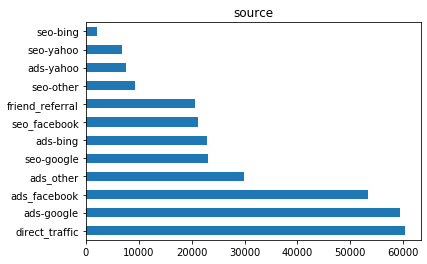

In [10]:
plot_col_bar('source',results_df)

This data itself looks OK although we should keep in mind the unequal distribution of sources and nans.

['mobile' 'web']


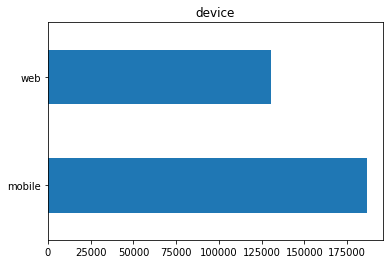

In [11]:
plot_col_bar('device',results_df)

pretty evenly distributed and no nans. this column is no trouble

['iOS' 'android' 'mac' 'windows' nan 'i0S' 'wnddows' 'anroid' 'apple']


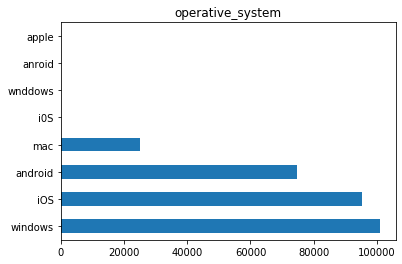

In [12]:
plot_col_bar('operative_system',results_df)

We'll need to convert the mispelled entries and also note there are nans. I'm also going to convert mac to iOS since I don't think there's any difference today.

In [13]:
op_sys_dict={'i0S':'iOS','wnddows':'windows','anroid':'android','apple':'iOS','mac':'iOS'}
results_df=results_df.replace({'operative_system':op_sys_dict})

In [14]:
results_df.operative_system.value_counts()

iOS        120550
windows    100976
android     74935
Name: operative_system, dtype: int64

operative_system looks good now, besides nans which we will deal with later

[0 1]


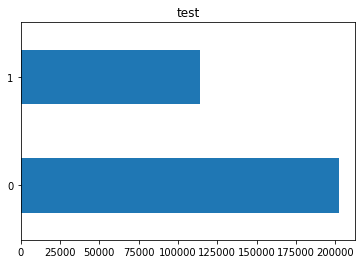

In [15]:
plot_col_bar('test',results_df)

This data looks ok and it seems that there was a ratio of 1:2 for test:non-test cases. This isn't ideal but isn't too bad for training a model

[0 1]


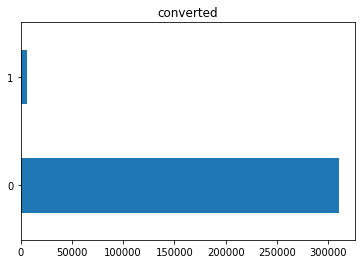

In [16]:
plot_col_bar('converted',results_df)

ok wow our target label which is the conversion rate of a customer buying the product is heavily unbalanced towards non-buyers. This mean's we will have to think carefully about how we split our data and what we are training on exactly.

Let's note cross tabulation of test and conversion frequencies so we can make sure we dont significantly change these as if we drop rows later.

In [17]:
print('Crosstab percents')
pd.crosstab(results_df.converted,results_df.test,normalize = True)

Crosstab percents


test,0,1
converted,,
0,0.627184,0.354482
1,0.012737,0.005597


In [18]:
print('Crosstab counts')
pd.crosstab(results_df.converted,results_df.test)

Crosstab counts


test,0,1
converted,,
0,198692,112300
1,4035,1773


Ok so we will try not to lose many of those 1s

Now let's finally take a look at the distribution of prices.

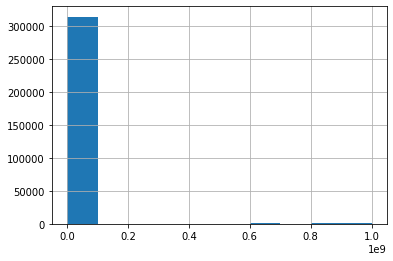

In [19]:
results_df.price.hist()

We thought we were getting either 39 or 59 but it looks like there's bad price data. let's see the value_counts

In [20]:
results_df.price.value_counts().head(20)

39.0           200747
59.0           112979
536537851.0         1
722005503.0         1
362003840.0         1
361763199.0         1
361601300.0         1
723198958.0         1
361468456.0         1
361357237.0         1
722266243.0         1
361101880.0         1
360980365.0         1
719974521.0         1
721845395.0         1
721543996.0         1
721022978.0         1
720964662.0         1
720460363.0         1
720433591.0         1
Name: price, dtype: int64

There's a bunch of bad pricing rows. We can acutally fix this column by using the test column which should map the price to 39 or 59 depending on 0 or 1 test. There were no nan's in test so this should fix every price row.

In [21]:
def get_price(test):
    if test ==1:
        return 59.0
    else:
        return 39.0

In [22]:
results_df.price=[get_price(test) for test in results_df.test.values]

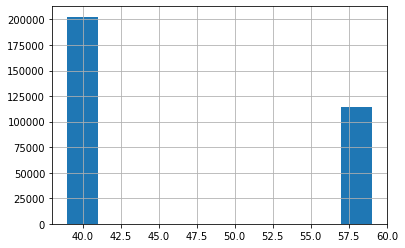

In [23]:
results_df.price.hist()

which now looks like it mimics the test column correctly.

So in all the data is now mostly ready from the results_df besides the nan values in source and operative_system. Let's see how many in each.

For source:

In [24]:
len(results_df.source)-len(results_df.source.dropna())

312

This isn't a lot compared to the number of rows or the number of unbalanced conversions so might be best to just drop these rows instead of guessing what operative system is best choice to assign them to.

and for operative_system:

In [25]:
len(results_df.operative_system)-len(results_df.operative_system.dropna())

20339

this is a significant portion. I don't think we want to drop these. Let's see how many positive conversions we will have if we do drop.

In [26]:
print('Crosstab counts')
print('\nOriginal')
print(pd.crosstab(results_df.converted,results_df.test,normalize = True))
print('\nDropped na')
print(pd.crosstab(results_df.dropna(how='any').converted,results_df.dropna(how='any').test,normalize = True))

Crosstab counts

Original
test              0         1
converted                    
0          0.627184  0.354482
1          0.012737  0.005597

Dropped na
test              0         1
converted                    
0          0.628006  0.353203
1          0.013014  0.005777


In [27]:
print('Crosstab counts')
print('\nOriginal')
print(pd.crosstab(results_df.converted,results_df.test))
print('\nDropped na')
print(pd.crosstab(results_df.dropna(how='any').converted,results_df.dropna(how='any').test))

Crosstab counts

Original
test            0       1
converted                
0          198692  112300
1            4035    1773

Dropped na
test            0       1
converted                
0          185790  104492
1            3850    1709


Looking at the noramlized tables, the test and conversion distributions stayed pretty stable. Concerning counts, we mostly lost samples from the non-converted rows which we still have plenty of data to sample from. 

We also lost very few from the test = 1, converted samples which is very good concerning later tests for significance of the test population. The test = 0, converted samples lost more but this actually makes our later stats tests more conservative because we will be looking to see if the test = 1 population had a significantly lower conversion rate. 

so I think it's reasonable to continue with this reduced dataset.

In [28]:
results_df_reduced = results_df.dropna(how='any')

Now let's check out the other table

## User table

In [29]:
user_df = pd.read_csv('user_table.csv')

In [30]:
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [31]:
len(user_df)-len(user_df.dropna(how='any'))

0

No nan values which is great. Before plotting cities, I suspect there is a lot so let's see how many cities their are.

In [32]:
len(user_df.city.unique())

923

That's a little too many to plot on a bar chart so let's just look at top value counts

In [33]:
user_df.city.value_counts().head(30)

New York          25748
Chicago            7153
Houston            6706
San Antonio        4633
Los Angeles        4141
San Jose           3354
Indianapolis       3217
Jacksonville       2905
Philadelphia       2541
Las Vegas          2426
Austin             2292
Seattle            2204
Oklahoma City      1796
Charlotte          1768
Tucson             1732
Virginia Beach     1712
Oakland            1686
Nashville          1581
Mesa               1557
Memphis            1540
Minneapolis        1466
Fort Worth         1429
Buffalo            1303
Raleigh            1293
New Orleans        1263
Springfield        1246
Tampa              1217
Dallas             1207
Detroit            1178
Plano              1079
Name: city, dtype: int64

Seems to be a somewhat exponentially distributed from the metro areas on outward... 

['USA']


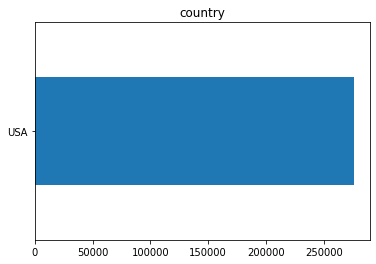

In [34]:
plot_col_bar('country',user_df)

looks like we can ignore this column

as for latitude and longitude, let's see if those are even any more granular than the city.

First lets print out the value counts for city, lat, lon

In [35]:
user_df.groupby(['city','lat','long']).agg(['count']).reset_index().city.value_counts().head(10)

Lakewood            5
Springfield         5
Saint Petersburg    4
Columbia            3
Fairfield           3
Newark              3
Albany              3
Lawrence            3
Arlington           3
Bloomington         3
Name: city, dtype: int64

ok lets also print the value counts for these values

In [36]:
user_df.groupby(['city','lat','long']).agg(['count']).reset_index().city.value_counts().to_frame().city.value_counts()

1    869
2     42
3      9
5      2
4      1
Name: city, dtype: int64

The city, lat, long groups seem to mostly have 1 lat,lon and at most 4. So I don't think lat,lon provides any diffentiating info from the city. Or the other way around. Considering how many cities we have that would need to be one-hot encoded in the final matrix before training. It's probably best we use lat, lon for our location data and drop city.

So in the end for the user_df, we are only concerned with lat, long

In [37]:
user_df_reduced = user_df[['user_id','lat','long']]

## Combining the data

first let's look at if we have all the same user ids to join on

In [38]:
len(results_df_reduced.user_id.unique())

295841

In [39]:
len(user_df_reduced.user_id.unique())

275616

we'll lose some results rows if we inner join for the lat,long data or we will have missing rows to think about.

let's first try the inner join and see how many positive conversion classes remain.

In [40]:
combined_df = pd.merge(results_df_reduced,user_df_reduced, on='user_id', how = 'inner')

Again lets look at the crosstabulation of test and conversion to make sure we didn't skew the sampling after

In [41]:
print('Crosstab counts')
print('\nOriginal')
print(pd.crosstab(results_df.converted,results_df.test,normalize = True))
print('\nCombined and Dropped nan')
print(pd.crosstab(combined_df.dropna(how='any').converted,combined_df.dropna(how='any').test,normalize = True))

Crosstab counts

Original
test              0         1
converted                    
0          0.627184  0.354482
1          0.012737  0.005597

Combined and Dropped nan
test              0         1
converted                    
0          0.628151  0.353155
1          0.012946  0.005748


In [42]:
print('Crosstab counts')
print('\nOriginal')
print(pd.crosstab(results_df.converted,results_df.test))
print('\nCombined and Dropped nan')
print(pd.crosstab(combined_df.dropna(how='any').converted,combined_df.dropna(how='any').test))

Crosstab counts

Original
test            0       1
converted                
0          198692  112300
1            4035    1773

Combined and Dropped nan
test            0      1
converted               
0          161622  90866
1            3331   1479


We've lost more rows in all categories but the ratios are still looking very similar so I think it's ok to work with this dataset going forward. We'll compare the stats to the original results_df at least once to make sure we don't get wildly different p-values.

# Answer Question 1?

First let's see which population (test 0 and 1) has the lower conversion rate.

In [43]:
combined_df[combined_df['test']==1]['converted'].value_counts(normalize=True)

0    0.983984
1    0.016016
Name: converted, dtype: float64

In [44]:
combined_df[combined_df['test']==0]['converted'].value_counts(normalize=True)

0    0.979806
1    0.020194
Name: converted, dtype: float64

Let's do that one check against the original dataset to make sure it looks similar.

In [45]:
results_df[results_df['test']==1]['converted'].value_counts(normalize=True)

0    0.984457
1    0.015543
Name: converted, dtype: float64

In [46]:
results_df[results_df['test']==0]['converted'].value_counts(normalize=True)

0    0.980096
1    0.019904
Name: converted, dtype: float64

So it looks like a smaller proportion of test subjects converted. If these differences are statistically significant, than we have to conclude that test subjects were less likely to convert. Given the large difference in sample sizes for test and non-test cases we need to run a statistical test and look at p-values

### Statistical Tests

Lets compute both the fisher exact and chi2_contingency tests for conversion given test or non-test populations. First we need the contingency (frequency) table using pandas:

In [47]:
from scipy import stats

In [48]:
crosstab = pd.crosstab(combined_df.converted,combined_df.test)
crosstab

test,0,1
converted,,
0,161622,90866
1,3331,1479


now the stats tests

In [49]:
fisher = stats.fisher_exact(crosstab)
print('fisher p-value {:.3e}'.format(fisher[1]))
chi2 = stats.chi2_contingency(crosstab)
print('chi2 p-value {:.3e}'.format(chi2[1]))

fisher p-value 3.499e-14
chi2 p-value 6.907e-14


With p-values close to 0, Both tests strongly support the rejection of the null hypothesis that these two populations are converting at the same rate. There's almost a 0 percent chance that the test sampling results could have been chosen at random if they were behaving similar to the non-test population.

Since we know the conversion rate is actually smaller for the test population, this is strong support that the test population had a statistically significant chance of lower conversion.

Just for good measure. let's run the test on the original dataset without all the dropped rows.

In [50]:
crosstab = pd.crosstab(results_df.converted,results_df.test)
crosstab

test,0,1
converted,,
0,198692,112300
1,4035,1773


In [51]:
fisher = stats.fisher_exact(crosstab)
print('fisher p-value {:.3e}'.format(fisher[1]))
chi2 = stats.chi2_contingency(crosstab)
fisher = stats.fisher_exact(crosstab)
print('chi2 p-value {:.3e}'.format(chi2[1]))

fisher p-value 6.685e-19
chi2 p-value 1.803e-18


OK so if anything, our cleaned dataset is a more conservative answer, the original dataset provides an even stronger argument for the test population being significantly lower conversion rates. 

But we can't quite answer question 1 yet. Just because few people convert doesn't mean the company didn't make more money due to the increase in price. So let's calculate the revenue per customer for both populations.

In [52]:
converted_test_num = combined_df.query("converted == 1 & test == 1").shape[0]
converted_test_revenu = converted_test_num*59
test_num = combined_df.query("test == 1").shape[0]
print('Test Revenue per Customer: ${:.2f}'.format(converted_test_revenu/test_num))

Test Revenue per Customer: $0.94


In [53]:
converted_nontest_num = combined_df.query("converted == 1 & test == 0").shape[0]
converted_nontest_revenu = converted_nontest_num*39
nontest_num = combined_df.query("test == 0").shape[0]
print('Non-Test Revenue per Customer: ${:.2f}'.format(converted_nontest_revenu/nontest_num))

Non-Test Revenue per Customer: $0.79


interesting! So the revenue per customer was actually higher for population that we just found was converted significantly less often.


## Answer 1: yes the company should sell at the higher price

We've learned that the test population has a stastically different behavior as seen from our chi2 test of their conversion rates. However the different behavior still resulted in more revenue / customer so yes the company should sell at the higher price.

## Sytematic Bias:

The chi2 test does not account for systematic bias between the populations so we do need to go back through our features and make sure the test and nontest populations do not have wildly different types of people.

Let's regenerate the bar plots from the beginning with the value_counts grouped by test and normalized. The bars should line up between test groups.

In [54]:
def bar_by_test(df,c):
    df = combined_df.groupby('test')[c].value_counts(normalize=True).to_frame().rename(columns={c:'counts'}).reset_index()
    sns.barplot(data=df,y=c, x='counts',hue='test',)

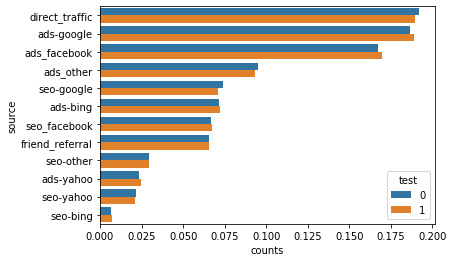

In [55]:
bar_by_test(combined_df,'source')

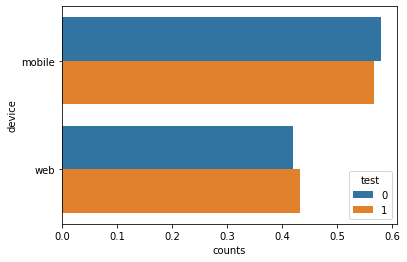

In [56]:
bar_by_test(combined_df,'device')

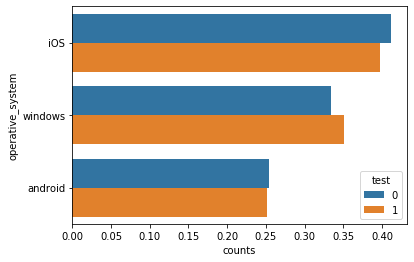

In [57]:
bar_by_test(combined_df,'operative_system')


In [58]:
combined_df['lat_long']=combined_df.apply(lambda x: str(x['lat'])+'_'+str(x['long']),axis=1)

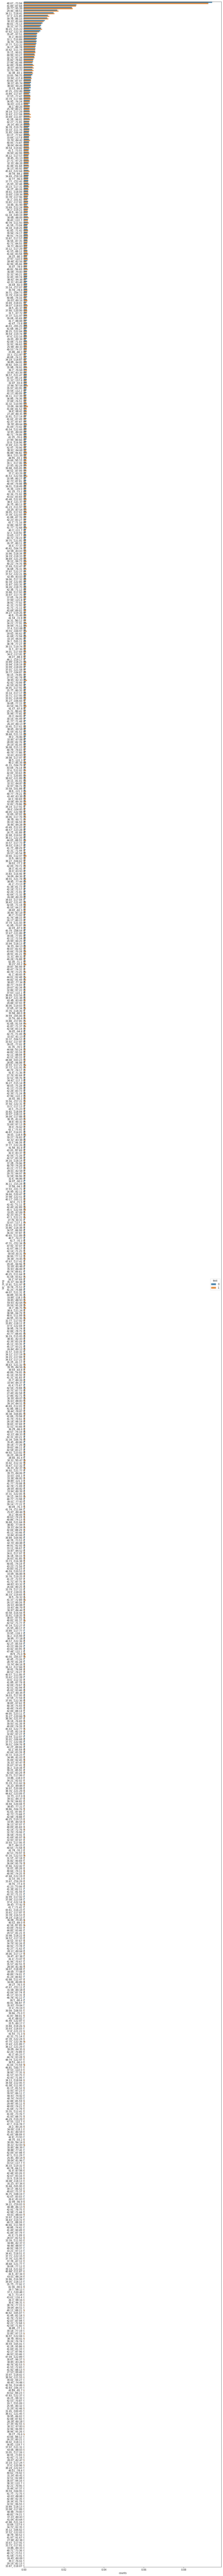

In [59]:
plt.figure(figsize=(15,200))
bar_by_test(combined_df,'lat_long')

It seems like the features are all quite well represented in both test and non-test samples.

### Like-distribution tests for each feature?

In [139]:
from scipy.stats import ks_2samp, mannwhitneyu, chi2_contingency

In [89]:
test_df = combined_df.query("test == 1")
nontest_df = combined_df.query("test == 0")

In [90]:
test_df.columns

Index(['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'lat', 'long', 'lat_long'],
      dtype='object')

In [106]:
ks_test_cols = ['source', 'device', 'operative_system', 'lat_long']

In [143]:
for col in ks_test_cols:
    crosstab = pd.crosstab(combined_df[col],combined_df.test)
    coef, p = chi2_contingency(crosstab)[:2]
    print(col+': ', 'Coef: {:.2f}, Pvalue: {:.2f}'.format(coef,p))

source:  Coef: 22.00, Pvalue: 0.02
device:  Coef: 34.33, Pvalue: 0.00
operative_system:  Coef: 81.19, Pvalue: 0.00
lat_long:  Coef: 2473.42, Pvalue: 0.00


It actually seems none of the feature distributions are matched between test and control groups. These should actually all be included as coveriates in a regression for the conversion rate.

In [120]:
from sklearn.preprocessing import LabelEncoder

In [144]:
crosstab

test,0,1
lat_long,,
19.7_-155.09,11,7
21.32_-157.8,215,115
25.67_-80.34,62,25
25.67_-80.44,75,50
25.71_-80.41,145,72
25.76_-80.4,112,78
25.77_-80.35,147,74
25.78_-80.21,466,257
25.7_-80.26,85,44


# Question 2:

For the second question we are tasked with finding what features correlate to conversion. We know the conversion rate is statistically different for the test and non-test populations so I'll answer this question separately for each group.

In [60]:
combined_df_dummies = pd.get_dummies(combined_df,columns = ['source','device','operative_system'])
combined_df_dummies.drop(columns = ['user_id','price'],inplace=True)

In [61]:
converted_corr_df = combined_df_dummies.groupby('test').corrwith(combined_df_dummies['converted'])

In [62]:
converted_corr_df.head()

,converted,lat,long,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_windows
test,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.005048,-0.003091,-0.012754,0.009045,-0.004407,0.013329,-0.011852,-0.022317,0.040438,0.004640,-0.004861,-0.002256,0.000402,-0.004242,0.000260,-0.000260,-0.017399,0.023362,-0.008314
1,1.0,-0.001615,0.003280,-0.012667,0.014627,-0.004106,0.006541,-0.005970,-0.022778,0.036259,-0.002747,0.001480,-0.004310,-0.006307,-0.004302,0.007254,-0.007254,-0.014947,0.026331,-0.013406


In [63]:
converted_corr_df.loc[0].sort_values(ascending = False)

converted                   1.000000
source_friend_referral      0.040438
operative_system_iOS        0.023362
source_ads_facebook         0.013329
source_ads-google           0.009045
source_seo-bing             0.004640
source_seo-yahoo            0.000402
device_mobile               0.000260
device_web                 -0.000260
source_seo-other           -0.002256
long                       -0.003091
source_seo_facebook        -0.004242
source_ads-yahoo           -0.004407
source_seo-google          -0.004861
lat                        -0.005048
operative_system_windows   -0.008314
source_ads_other           -0.011852
source_ads-bing            -0.012754
operative_system_android   -0.017399
source_direct_traffic      -0.022317
Name: 0, dtype: float64

In [64]:
converted_corr_df.loc[1].sort_values(ascending = False)

converted                   1.000000
source_friend_referral      0.036259
operative_system_iOS        0.026331
source_ads-google           0.014627
device_mobile               0.007254
source_ads_facebook         0.006541
long                        0.003280
source_seo-google           0.001480
lat                        -0.001615
source_seo-bing            -0.002747
source_ads-yahoo           -0.004106
source_seo_facebook        -0.004302
source_seo-other           -0.004310
source_ads_other           -0.005970
source_seo-yahoo           -0.006307
device_web                 -0.007254
source_ads-bing            -0.012667
operative_system_windows   -0.013406
operative_system_android   -0.014947
source_direct_traffic      -0.022778
Name: 1, dtype: float64

In both sample cases, there's really no feature with a very strong correlation coef. The only factor that might deserve consideration is friend referrals, which has a high postive correlation to conversion. Then possibly how Apple users tend to convert whereas windows and android users tend not to, which is interesting. Finally it seems direct traffic is worse whereas most other sources do not have much correlation.

## Answer 2: Friend referrals are most likely, 

Apple users somehwhat more likely while android/windows are less likely. Direct traffic less likely to convert.

# Question 3: when test could have stopped.

I'm going to skip to question 3 and determine if this test could have ended earlier. I'll do this by plotting the rolling chi2 p-value vs. datetime for the test vs non-test conversion rates and overlay the rolling revenue per customer. When the p-value drops below 5% and the revenue per customer is higher

## Time-dependence

### Cleaning datetime

Before doing that we need to make sure the datetime data is good to go. 

I'm going to look at the reduced results_df table just to make sure I catch all datetime issues that we might have dropped during the inner join with the user_df. I'll apply any pipelines to combined_df along the way.

In [65]:
try:
    pd.to_datetime(results_df_reduced.timestamp)
except Exception as e:
    print(e)

minute must be in 0..59


That's odd, let's look at some dates

In [66]:
results_df_reduced.timestamp.head()

0    2015-05-08 03:38:34
1    2015-05-10 21:08:46
2    2015-04-04 15:01:23
3    2015-05-07 07:26:01
4    2015-05-24 11:04:40
Name: timestamp, dtype: object

don't see anything. Let's split these strings by : and look at the unique minutes

In [67]:
minutes = results_df_reduced.timestamp.str.split(':').apply(lambda x: int(x[-2])).unique()
minutes.sort()
minutes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

Odd. the minutes go from 1-60 instead of 0-59. What about seconds?

In [68]:
seconds = results_df_reduced.timestamp.str.split(':').apply(lambda x: int(x[-1])).unique()
seconds.sort()
seconds

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

Same issue. Let's make sure the hours aren't weird either.

In [69]:
hours = results_df_reduced.timestamp.str.split(':').apply(lambda x: int(x[-3].split(' ')[-1])).unique()
hours.sort()
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

OK hours are ok. Let's fix minutes and seconds by subtracting 1 from all of them.

In [70]:
def fix_dt(dt):
    leading, minute, second = dt.split(':')
    minute = str(int(minute)-1)
    second = str(int(second)-1)
    return '{}:{}:{}'.format(leading,minute,second)

In [71]:
results_df_reduced.timestamp = results_df_reduced.timestamp.apply(fix_dt)
combined_df.timestamp = combined_df.timestamp.apply(fix_dt)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [72]:
results_df_reduced.timestamp.head()

0    2015-05-08 03:37:33
1     2015-05-10 21:7:45
2     2015-04-04 15:0:22
3     2015-05-07 07:25:0
4     2015-05-24 11:3:39
Name: timestamp, dtype: object

In [73]:
try:
    pd.to_datetime(results_df_reduced.timestamp)
except Exception as e:
    print(e)

Out of bounds nanosecond timestamp: 2815-04-11 11:22:53


looks like some years have typos

In [74]:
results_df_reduced.timestamp.str.split('-').apply(lambda x: x[0]).value_counts()

2015    295546
2815       295
Name: timestamp, dtype: int64

this can be handled with a string replace

In [75]:
results_df_reduced.timestamp = results_df_reduced.timestamp.str.replace('2815','2015')
combined_df.timestamp = combined_df.timestamp.str.replace('2815','2015')

In [76]:
results_df_reduced.timestamp = pd.to_datetime(results_df_reduced.timestamp)
combined_df.timestamp = pd.to_datetime(combined_df.timestamp)

finally we have datetime column. Lets plot conversions colored by test over time to see if we roughly have continued conversions from both samples

In [77]:
import datetime

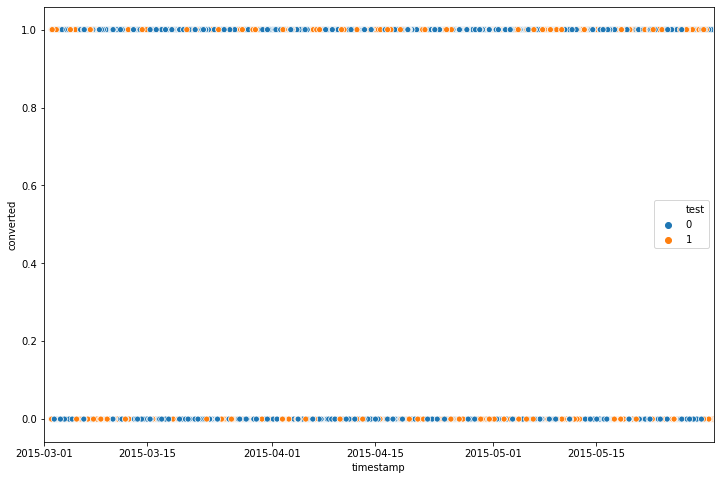

In [78]:
fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(data = combined_df, x = 'timestamp',y='converted',hue='test')
ax.set_xlim([datetime.date(2015, 3, 1), datetime.date(2015, 5, 31)])
plt.show()

This looks good for now. I see test conversions continuing throughout the test period. Later on we will look at the rolling conversion just to make sure this isn't dropping after a while of seeing the higher price.

## Chi2 and RPC Trends

but first let's calculate the cumulative chi2 and revenue per customer starting somewhere into the study when a little data has already accumulated.

Let's see what the test date range looks like

In [79]:
combined_df = combined_df.sort_values('timestamp')

In [80]:
print('Non-test start:', combined_df.query('test==0').timestamp.min(),
      'and Test Start:',combined_df.query('test==1').timestamp.min())
print('Non-test End:', combined_df.query('test==0').timestamp.max(),
      'and Test End:',combined_df.query('test==1').timestamp.max())

Non-test start: 2015-03-02 00:11:39 and Test Start: 2015-03-02 00:03:11
Non-test End: 2015-05-31 23:58:44 and Test End: 2015-05-31 23:49:12


That looks good, let's now count the days and determine what our rolling window will be

In [81]:
(combined_df.timestamp.max()-combined_df.timestamp.min())

Timedelta('90 days 23:55:33')

OK let's start say 5 days into the study and calcuate the cumulative chi2 and revenure per customer for every timestamp after that.

In [82]:
combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

In [83]:
index_at_day_5 = combined_df[combined_df['timestamp']>combined_df['timestamp'].iloc[0]+pd.Timedelta('5 days')].index[0]
print('5 days in is:',combined_df.iloc[index_at_day_5].timestamp, ', with an index of', index_at_day_5 )

5 days in is: 2015-03-07 00:03:30 , with an index of 11800


OK so we know which row to start with, now we'll make a function that takes in subsets of the data and returns the chi2 and revenue per customer (rps)

In [140]:
def get_chi2_and_rpc(mini_df):
    crosstab = pd.crosstab(mini_df.converted, mini_df.test)
    chi_p = stats.chi2_contingency(crosstab)[1]
    
    converted_test_rev = mini_df.query("converted == 1 & test == 1").shape[0]*59
    test_num = mini_df.query("test == 1").shape[0]
    test_rps = converted_test_rev/test_num
    
    converted_rev =  mini_df.query("converted == 1 & test == 0").shape[0]*39
    num = mini_df.query("test == 0").shape[0]
    rps = converted_rev/num
    
    return chi_p, test_rps, rps

Let's start near the beginning of the dataset (5 datapoints in) and sample the stats every 1000 data points for the whole test.

In [141]:
def get_statstrend_df(step_size=200, breakearly=True):
    timestamps = []
    chi2 = []
    rps_test = []
    rps_nontest = []

    for i in range(5, len(combined_df), step_size):
        timestamps.append(combined_df.timestamp.iloc[i])
        c, rt, rnt = get_chi2_and_rpc(combined_df.iloc[:i])
        chi2.append(c)
        rps_test.append(rt)
        rps_nontest.append(rnt)
        
        if breakearly:
            if c < 0.01 and rt > rnt+.1:
                break

    trend = pd.DataFrame({
        'timestamp':timestamps,
        'chi2':chi2,
        'rps_test':rps_test,
        'rps_nontest':rps_nontest
    })
    return trend

In [142]:
full_trend = get_statstrend_df(step_size=1000,breakearly=False)
full_trend.head()

,timestamp,chi2,rps_test,rps_nontest
0,2015-03-02 00:17:45,1.000000,0.000000,0.000000
1,2015-03-02 16:40:33,0.488674,1.300275,0.546729
2,2015-03-03 12:49:06,0.425754,0.866489,0.807325
3,2015-03-04 11:22:10,0.064336,0.700457,0.857592
4,2015-03-05 07:31:28,0.077404,0.882479,0.929642


Lots of changes happening from the beginning, let's plot it out

In [143]:
from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource,HoverTool, Span, Label
from bokeh.core.properties import value
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [144]:
def bokeh_plot_stats(df):
    p = figure(
        x_axis_type="datetime",
        tools = ["pan","box_zoom","tap","reset"],
        plot_height = 600,
        plot_width = 800,
        title = 'Weekly Play Trend'
    )

    src = ColumnDataSource(df)

    p.circle('timestamp','chi2',source=src,legend=value('chi2'))
    p.line('timestamp','chi2',source=src,legend=value('chi2'))
    p.circle('timestamp','rps_test',source=src, color = 'red',legend=value('RPS test'))
    p.line('timestamp','rps_test',source=src, color = 'red',legend=value('RPS test'))
    p.circle('timestamp','rps_nontest',source=src, color = 'black',legend=value('RPS non-test'))
    p.line('timestamp','rps_nontest',source=src, color = 'black',legend=value('RPS non-test'))

    sig_level = Span(location=0.05,dimension='width',line_color='green', line_width=2, line_alpha=.7)
    my_label = Label(x=pd.to_datetime("5-15-2015"), y=.05, text='5% Significance',text_color='green')
    p.add_layout(my_label)
    p.add_layout(sig_level)

    hover = HoverTool(
                tooltips=[

                    ("Date", "@timestamp{%F}"),
                    ("Chi2", "@chi2"),
                    ("RPC test", "@rps_test"),
                    ("RPC non-test", "@rps_nontest"),
                ],
                formatters={
                        'timestamp':"datetime"}
                )
    p.tools.append(hover)
    p.xaxis.major_label_orientation=3.14/4
    p.legend.location = "top_right"
    p.legend.click_policy="hide"
    show(p)

In [145]:
bokeh_plot_stats(full_trend)

Everything was a bit unstable and the chi2 p-value was above 5% until roughly 3-28. After that the RPC and p-value are quite stable with the test RPC staying well above the control RPC. If we stopped 3-28 however we might not have been able to see if the RPCs were going to converge or not. If that's a worry, you might want to have waited intil 5/15.

### Answer 2: The test could have finished on March 28 or 26 days into the test unless there was concern about RPC not being stable.

### Note on Rolling conversion rate trends

We might have wanted to look at the rolling window conversion rate trend for the test and control sets but with the RPCs staying quite stable for the last 3rd of the experiment, there doesn't seem to be concern for the test conversion rate to move.